# Zsoft challenge by HAICK
Using transformers, this notebook demonstrates how to classify resume snippets into their respective sections, as part of a Kaggle challenge from a datathon hosted by the `School of AI Algiers`.

## Importing packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

import torch
import random
np.random.seed(42)
np.random.RandomState(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
train_df = pd.read_csv('Train_zsoft.csv')
test_df = pd.read_csv('Test_zsoft.csv')
Sample_Submission = pd.read_csv('SampleSubmission_zsoft.csv')

## Explore the datasets

In [3]:
train_df.head()

,ID,text,label
0,17428,TRANSPORT SYTEX / OEDA,Experience
1,15362,Appliquer la résine Avancé,Skills
2,37153,2020 - 2021 ¢ Formation en ligne sur le,Education
3,10240,Score: 820 (B2),Skills
4,29713,- Anglais :courant - Créole :courant,Skills


In [4]:
test_df.head()

,ID,text
0,31507,e Coordinating and distributing shooting sched...
1,12238,Dipl6me Universitaire en Production de Contenu...
2,37232,Professeur Patrick Cohen.
3,22248,"e Autonomie, sens de la responsabilité"
4,4589,2021-2023 2020-2021 2017-2019


In [5]:
Sample_Submission.head()

,ID,label
0,31507,Education
1,12238,Education
2,37232,Education
3,22248,Education
4,4589,Education


Experience    16352
Skills         7691
Education      6086
Name: label, dtype: int64

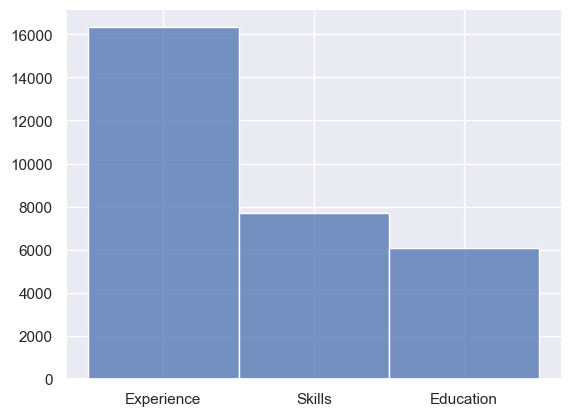

In [6]:
# plot the label distribution
display(train_df.label.value_counts())
sns.histplot(train_df.label)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [8]:
# This is a function I generally use to summarize information about my sets :
def summary(data) : 
    """ The function takes a pandas dataframe and create a summary about missing and unique values of that dataframe """
    result = (pd.DataFrame(data.dtypes, columns=["Data Type"]).reset_index().rename(columns={'index': 'Column'}))
    result["Unique"] = data.nunique().values
    result["Null"] = data.isna().sum().values
    result["%null"] = np.round(data.isna().sum().values / data.shape[0] * 100, decimals=2)
    return result

In [9]:
summary(train_df)

,Column,Data Type,Unique,Null,%null
0,ID,int64,30129,0,0.0
1,text,object,28378,0,0.0
2,label,int64,3,0,0.0


In [10]:
summary(test_df)

,Column,Data Type,Unique,Null,%null
0,ID,int64,7533,0,0.0
1,text,object,7361,0,0.0


In [11]:
train_df['text'].duplicated().sum()

1751

In [12]:
test_df['text'].duplicated().sum()

172

We can clearly see that there is some duplicated text.<br>
Let's check if the ones in the training data have different labels.

In [13]:
duplicate_text_with_different_labels = train_df.groupby('text')['label'].nunique() > 1
train_df[train_df['text'].isin(duplicate_text_with_different_labels[duplicate_text_with_different_labels].index)]

,ID,text,label
97,13253,Relation client,1
109,17053,Bordeaux,0
124,7574,2020-2022,0
135,22952,- Recrutement,1
216,37614,France,0
...,...,...,...
29794,8311,Gestion des réseaux sociaux,0
29822,10966,2022-2023,2
29847,16538,Lille,0
29877,27643,Mise en rayon des produits,0


In [14]:
train_df[train_df['text']=='2020-2022']

,ID,text,label
124,7574,2020-2022,0
1725,7165,2020-2022,0
12622,21413,2020-2022,2
19250,8625,2020-2022,2
22224,10970,2020-2022,2
25259,6040,2020-2022,2
29132,21389,2020-2022,0


In [15]:
test_df[test_df['text']=='2020-2021']

,ID,text
6852,3341,2020-2021


Upon inspecting the cases where different labels are assigned to the same text, I observed that there is some logic to it.<br>
This is because there is a nuanced difference between the categories; some phrases can describe both skills and experience.<br>
Additionally, it's worth noting that in both education and experience, we mention years <b>!!<b>

In [7]:
# Encode the label values
train_df['label']=train_df['label'].map({'Experience':0, 'Skills':1, 'Education':2})

## Preprocessing

In [16]:
# Transform my pandas dataframe into a dataset the can be fed to the transformer
from datasets import Dataset
dataset = Dataset.from_pandas(train_df)
dataset

In [18]:
# This is a function I used to lowercase the text
def lowercase_text(example):
    """ It takes as argument the text from the text column in my dataset and return its lowercased version """
    return {"text": example["text"].lower()}


dataset = dataset.map(lowercase_text)

Map:   0%|          | 0/30129 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'text', 'label'],
    num_rows: 30129
})

In [19]:
# Train, validation split
datasets = dataset.train_test_split(train_size=0.8, seed=42)
datasets["validation"] = datasets.pop("test")
datasets

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'label'],
        num_rows: 24103
    })
    validation: Dataset({
        features: ['ID', 'text', 'label'],
        num_rows: 6026
    })
})

## Modeling

In [21]:
# Load the camembert model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
model = AutoModelForSequenceClassification.from_pretrained('camembert-base', num_labels=3)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# This is a function I used to tokenize the texts
def tokenize_function(example):
    """ It takes as argument the text from the text column in my dataset and return its tokenized version """

    return tokenizer(example['text'], truncation=True)

In [23]:
tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/24103 [00:00<?, ? examples/s]

Map:   0%|          | 0/6026 [00:00<?, ? examples/s]

In [24]:
# Removing unneeded columns
tokenized_datasets = tokenized_datasets.remove_columns(['text', 'ID'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [25]:
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [26]:
# Creating the dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [27]:
# Trying an example to make sure everything works fine (I am always afraid of errors :p)
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 21]),
 'attention_mask': torch.Size([8, 21])}

In [28]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.1211, grad_fn=<NllLossBackward0>) torch.Size([8, 3])


<b>Everything looks fine !!</b><br>
Let's build our training loop

In [29]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [30]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

9039


## Training

In [31]:
# Using my gpu to make training faster
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

  0%|          | 0/9039 [00:00<?, ?it/s]

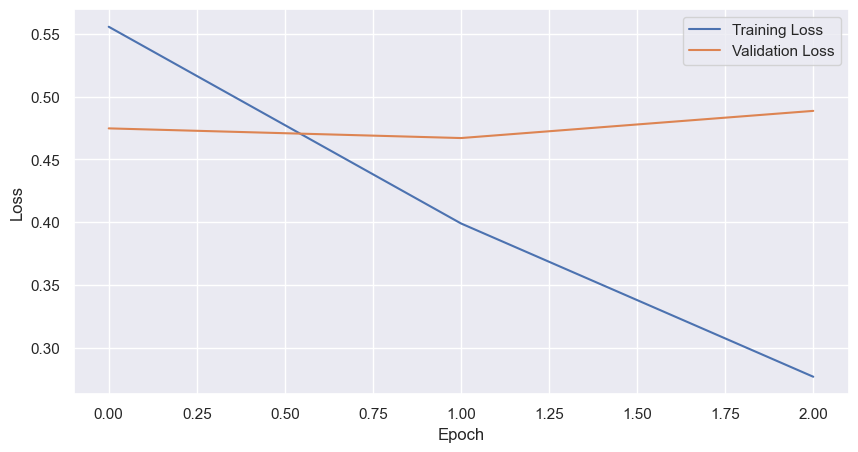

In [32]:
# Training loop

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
training_losses = []  # To store training losses
validation_losses = []  # To store validation losses

model.train()
for epoch in range(num_epochs):
    epoch_training_loss = 0.0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_training_loss += loss.item()

        progress_bar.update(1)

    # Calculate and record the average training loss for the epoch
    avg_training_loss = epoch_training_loss / len(train_dataloader)
    training_losses.append(avg_training_loss)

    # Calculate the validation loss at the end of each epoch
    model.eval()
    with torch.no_grad():
        epoch_validation_loss = 0.0
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_validation_loss += loss.item()

        avg_validation_loss = epoch_validation_loss / len(val_dataloader)
        validation_losses.append(avg_validation_loss)

    model.train()

# Plot the training and validation losses variation over the epochs
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating on the validation dataset

In [33]:
# The metric used in the challenge is accuracy
import evaluate
metric = evaluate.load("accuracy")

Using the latest cached version of the module from C:\Users\ACER\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Wed Sep 27 16:03:30 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


In [34]:
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    labels = batch["labels"]

    metric.add_batch(predictions=predictions, references=labels)

In [35]:
# Calculate the accuracy
accuracy = metric.compute()
accuracy

{'accuracy': 0.8315632260205775}

<b>That's a good accuracy !</b><br>
Let's retrain the model using all of the training data.<br>
Initially, I used a training/validation split to assess the model's performance. Now, I will train it on the entire training dataset and then use it to make predictions on the test dataset, filling the submission dataframe's target column.

## Training on all train data

In [36]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
model = AutoModelForSequenceClassification.from_pretrained('camembert-base', num_labels=3)
model.to(device)
device

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [37]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/30129 [00:00<?, ? examples/s]

In [38]:
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'ID'])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

In [39]:
tokenized_dataset.column_names

['labels', 'input_ids', 'attention_mask']

In [40]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset, shuffle=True, batch_size=8, collate_fn=data_collator
)

In [41]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 32]),
 'attention_mask': torch.Size([8, 32])}

In [44]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [45]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

11301


In [46]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/11301 [00:00<?, ?it/s]

## Predicting test samples

In [47]:
test_dataset = Dataset.from_pandas(test_df.drop('ID', axis=1))
test_dataset

Dataset({
    features: ['text'],
    num_rows: 7533
})

In [48]:
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/7533 [00:00<?, ? examples/s]

In [49]:
test_dataloader = DataLoader(
    tokenized_test_dataset.remove_columns('text'), batch_size=8, collate_fn=data_collator
)

In [50]:
y_pred = []
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    y_pred.extend(predictions.tolist())

In [51]:
test_df['label'] = y_pred
test_df.head()

,ID,text,label
0,31507,e Coordinating and distributing shooting sched...,0
1,12238,Dipl6me Universitaire en Production de Contenu...,2
2,37232,Professeur Patrick Cohen.,2
3,22248,"e Autonomie, sens de la responsabilité",1
4,4589,2021-2023 2020-2021 2017-2019,2


In [52]:
test_df['label']=test_df['label'].map({0:'Experience', 1:'Skills', 2:'Education'})
test_df.head()

,ID,text,label
0,31507,e Coordinating and distributing shooting sched...,Experience
1,12238,Dipl6me Universitaire en Production de Contenu...,Education
2,37232,Professeur Patrick Cohen.,Education
3,22248,"e Autonomie, sens de la responsabilité",Skills
4,4589,2021-2023 2020-2021 2017-2019,Education


In [53]:
((Sample_Submission['ID'] == test_df['ID'])!=True).sum()

0

The test and the submission dataframes has the same order.

In [54]:
Sample_Submission['label']=test_df['label']
Sample_Submission.head()

,ID,label
0,31507,Experience
1,12238,Education
2,37232,Education
3,22248,Skills
4,4589,Education


In [55]:
Sample_Submission.to_csv('Submissions/submission_2.csv', index=False)